Esteban Castañeda Blanco C01795

Israel López Vallecillo C04396

Daniel Lizano Morales C04285

Ariel Solís Monge B97664

In [1]:
import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import config
import wandb 

/Users/daniellizano/Documents/plant_disease_classification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
wandb.login(key=config.API_KEY)

In [2]:
labeled_train_relative_set_size = round((config.LABELED_TRAIN_SET_ABSOLUTE_SIZE / (1 - config.UNLABELED_SET_SIZE)), 2)
labeled_test_relative_set_size = 1 - labeled_train_relative_set_size

## Datasets and dataloaders

In [3]:
data_transforms = {
    'bce': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
    'mse': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.4641, 0.4891, 0.4096], [0.1883, 0.1621, 0.2068])
    ]),
    'dispersion_calc': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

In [4]:
full_dataset = datasets.ImageFolder(config.BASE_DIR_RAW, transform=data_transforms[config.AE_TRANSFORMS])

In [5]:
indices = list(range(len(full_dataset)))

# Get the directory paths of images
image_paths = [sample[0] for sample in full_dataset.samples]

labels = [os.path.split(os.path.dirname(path))[-1] for path in image_paths]

In [6]:
#Obtenemos el 20% de los datos 
train_val_indices, _ = train_test_split(indices, test_size=config.UNLABELED_SET_SIZE, stratify=labels, random_state=42)

#Obtenemos las etiquetas de los datos de entrenamiento
train_val_labels = [labels[i] for i in train_val_indices]

#dividir el 20% en 10% de entrenamiento y 10% de validación
train_indices, val_indices = train_test_split(train_val_indices, test_size=labeled_test_relative_set_size, stratify=train_val_labels, random_state=42)

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=config.CNN_BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=config.CNN_BATCH_SIZE, shuffle=False, num_workers=4)

print(f"Número de imágenes en el conjunto de entrenamiento: {len(train_loader.dataset)}")
print(f"Número de imágenes en el conjunto de validación: {len(val_loader.dataset)}")

Número de imágenes en el conjunto de entrenamiento: 6148
Número de imágenes en el conjunto de validación: 6149


## Function definitions

In [8]:
def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='g', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    return figure

In [9]:
def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10, patience=3):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    wandb.init(project="cnn_raw_training")
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc
        })
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), config.CNN_SAVE_PATH)
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break
    
    return model

In [13]:
def evaluate_model(model_path, dataloader, device):
    model = models.efficientnet_b2(pretrained=False)
    new_in_channels = config.CHANNELS
    original_conv1 = model.features[0][0]
    wandb.init(project="cnn_raw_evaluation")

    new_conv1 = nn.Conv2d(
        in_channels=new_in_channels,
        out_channels=original_conv1.out_channels,
        kernel_size=original_conv1.kernel_size,
        stride=original_conv1.stride,
        padding=original_conv1.padding,
        bias=original_conv1.bias
    )
    with torch.no_grad():
        if new_in_channels == 1:
            new_conv1.weight = nn.Parameter(original_conv1.weight.mean(dim=1, keepdim=True))
        else:
            new_conv1.weight[:, :3] = original_conv1.weight
            if new_in_channels > 3:
                for i in range(3, new_in_channels):
                    new_conv1.weight[:, i:i+1] = original_conv1.weight.mean(dim=1, keepdim=True)
    model.features[0][0] = new_conv1
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, class_names=dataloader.dataset.dataset.classes)
    class_names = dataloader.dataset.dataset.classes
    precision = precision_score(all_labels, all_preds, average=None)
    recall = recall_score(all_labels, all_preds, average=None)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    
    print(f'Overall Accuracy: {accuracy:.4f}')
    print("\nMetrics by Class:")
    print("{:<20} {:<10} {:<10} {:<10}".format("Class", "Accuracy", "Precision", "Recall"))
    print("="*50)
    for class_name, class_accuracy, class_precision, class_recall in zip(class_names, class_accuracies, precision, recall):
        print("{:<20} {:<10.4f} {:<10.4f} {:<10.4f}".format(class_name, class_accuracy, class_precision, class_recall))

    wandb.log({
        "overall_accuracy": accuracy,
        "confusion_matrix": wandb.plot.confusion_matrix(probs=None, y_true=all_labels, preds=all_preds, class_names=class_names),
        "precision": {class_name: class_precision for class_name, class_precision in zip(class_names, precision)},
        "recall": {class_name: class_recall for class_name, class_recall in zip(class_names, recall)},
        "class_accuracies": {class_name: class_accuracy for class_name, class_accuracy in zip(class_names, class_accuracies)}
    })
    
    return accuracy

## CNN Classifier

In [11]:
# Set up of the device
if torch.backends.mps.is_available():
    device = torch.device("mps")#tqm
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")
model = models.efficientnet_b2()

# Modify the first convolutional layer to accept a different number of input channels (e.g., 1 instead of 3)
new_in_channels = config.CHANNELS  # Change this to the desired number of input channels
original_conv1 = model.features[0][0]

new_conv1 = nn.Conv2d(
    in_channels=new_in_channels,
    out_channels=original_conv1.out_channels,
    kernel_size=original_conv1.kernel_size,
    stride=original_conv1.stride,
    padding=original_conv1.padding,
    bias=original_conv1.bias
)

# Initialize the weights of the new conv layer
with torch.no_grad():
    if new_in_channels == 1:
        # Average the weights of the original conv layer across the input channels
        new_conv1.weight = nn.Parameter(original_conv1.weight.mean(dim=1, keepdim=True))
    else:
        # Initialize weights by repeating the mean weights or use a different strategy
        new_conv1.weight[:, :3] = original_conv1.weight
        if new_in_channels > 3:
            for i in range(3, new_in_channels):
                new_conv1.weight[:, i:i+1] = original_conv1.weight.mean(dim=1, keepdim=True)

# Replace the first convolutional layer in the model
model.features[0][0] = new_conv1

# Print the modified first convolutional layer
print("Modified first conv layer:", model.features[0][0])
# model._conv_stem = nn.Conv2d(1, model._conv_stem.out_channels, kernel_size=model._conv_stem.kernel_size, stride=model._conv_stem.stride, padding=model._conv_stem.padding, bias=False)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

Using device: mps
Modified first conv layer: Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)


### Training

In [12]:
trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=config.EPOCHS, patience=config.PATIENCE)

100%|██████████| 193/193 [02:13<00:00,  1.45it/s]


Epoch 1/30
Train Loss: 3.1674 Acc: 0.2222
Val Loss: 2.6223 Acc: 0.2589


100%|██████████| 193/193 [02:05<00:00,  1.53it/s]


Epoch 2/30
Train Loss: 2.2317 Acc: 0.3684
Val Loss: 2.0337 Acc: 0.4209


100%|██████████| 193/193 [02:05<00:00,  1.54it/s]


Epoch 3/30
Train Loss: 1.7437 Acc: 0.4885
Val Loss: 1.3821 Acc: 0.5850


100%|██████████| 193/193 [02:05<00:00,  1.54it/s]


Epoch 4/30
Train Loss: 1.4021 Acc: 0.5701
Val Loss: 1.5221 Acc: 0.5326


100%|██████████| 193/193 [02:05<00:00,  1.54it/s]


Epoch 5/30
Train Loss: 1.1119 Acc: 0.6493
Val Loss: 0.9638 Acc: 0.7052


100%|██████████| 193/193 [02:05<00:00,  1.54it/s]


Epoch 6/30
Train Loss: 0.9292 Acc: 0.7103
Val Loss: 0.9125 Acc: 0.7169


100%|██████████| 193/193 [02:06<00:00,  1.52it/s]


Epoch 7/30
Train Loss: 0.7866 Acc: 0.7531
Val Loss: 0.6741 Acc: 0.7832


100%|██████████| 193/193 [02:06<00:00,  1.52it/s]


Epoch 8/30
Train Loss: 0.6721 Acc: 0.7840
Val Loss: 0.6340 Acc: 0.7987


100%|██████████| 193/193 [02:05<00:00,  1.54it/s]


Epoch 9/30
Train Loss: 0.5636 Acc: 0.8191
Val Loss: 0.7243 Acc: 0.7744


100%|██████████| 193/193 [02:05<00:00,  1.54it/s]


Epoch 10/30
Train Loss: 0.5089 Acc: 0.8312
Val Loss: 0.4686 Acc: 0.8458


100%|██████████| 193/193 [02:05<00:00,  1.53it/s]


Epoch 11/30
Train Loss: 0.4450 Acc: 0.8549
Val Loss: 0.4925 Acc: 0.8462


100%|██████████| 193/193 [02:05<00:00,  1.54it/s]


Epoch 12/30
Train Loss: 0.4078 Acc: 0.8684
Val Loss: 0.4378 Acc: 0.8597


100%|██████████| 193/193 [02:05<00:00,  1.54it/s]


Epoch 13/30
Train Loss: 0.3369 Acc: 0.8970
Val Loss: 0.4587 Acc: 0.8567


100%|██████████| 193/193 [02:05<00:00,  1.54it/s]


Epoch 14/30
Train Loss: 0.3774 Acc: 0.8735
Val Loss: 0.4881 Acc: 0.8535


100%|██████████| 193/193 [02:05<00:00,  1.54it/s]


Epoch 15/30
Train Loss: 0.2845 Acc: 0.9034
Val Loss: 0.3662 Acc: 0.8826


100%|██████████| 193/193 [02:05<00:00,  1.53it/s]


Epoch 16/30
Train Loss: 0.2588 Acc: 0.9125
Val Loss: 0.4190 Acc: 0.8808


100%|██████████| 193/193 [02:05<00:00,  1.54it/s]


Epoch 17/30
Train Loss: 0.2547 Acc: 0.9182
Val Loss: 0.3442 Acc: 0.8951


100%|██████████| 193/193 [02:05<00:00,  1.54it/s]


Epoch 18/30
Train Loss: 0.2570 Acc: 0.9180
Val Loss: 0.5034 Acc: 0.8566


100%|██████████| 193/193 [02:05<00:00,  1.54it/s]


Epoch 19/30
Train Loss: 0.2125 Acc: 0.9318
Val Loss: 0.3167 Acc: 0.9063


100%|██████████| 193/193 [02:05<00:00,  1.54it/s]


Epoch 20/30
Train Loss: 0.2095 Acc: 0.9283
Val Loss: 0.3547 Acc: 0.8919


100%|██████████| 193/193 [02:05<00:00,  1.54it/s]


Epoch 21/30
Train Loss: 0.1761 Acc: 0.9465
Val Loss: 0.3040 Acc: 0.9018


100%|██████████| 193/193 [02:05<00:00,  1.54it/s]


Epoch 22/30
Train Loss: 0.1650 Acc: 0.9470
Val Loss: 0.4286 Acc: 0.8800


100%|██████████| 193/193 [02:05<00:00,  1.54it/s]


Epoch 23/30
Train Loss: 0.1244 Acc: 0.9616
Val Loss: 0.4520 Acc: 0.8715


100%|██████████| 193/193 [02:05<00:00,  1.54it/s]


Epoch 24/30
Train Loss: 0.2076 Acc: 0.9302
Val Loss: 0.2930 Acc: 0.9127


100%|██████████| 193/193 [02:05<00:00,  1.54it/s]


Epoch 25/30
Train Loss: 0.1202 Acc: 0.9623
Val Loss: 0.3061 Acc: 0.9125


100%|██████████| 193/193 [02:06<00:00,  1.52it/s]


Epoch 26/30
Train Loss: 0.1885 Acc: 0.9390
Val Loss: 0.3625 Acc: 0.8980


100%|██████████| 193/193 [02:05<00:00,  1.54it/s]


Epoch 27/30
Train Loss: 0.1313 Acc: 0.9571
Val Loss: 0.3502 Acc: 0.9063


100%|██████████| 193/193 [02:04<00:00,  1.55it/s]


Epoch 28/30
Train Loss: 0.1419 Acc: 0.9554
Val Loss: 0.3403 Acc: 0.9052


100%|██████████| 193/193 [02:04<00:00,  1.54it/s]


Epoch 29/30
Train Loss: 0.1087 Acc: 0.9668
Val Loss: 0.3305 Acc: 0.9091
Early stopping triggered!


In [11]:

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='g', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

Using device: mps


### Evaluation

/Users/daniellizano/Documents/plant_disease_classification/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/daniellizano/Documents/plant_disease_classification/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


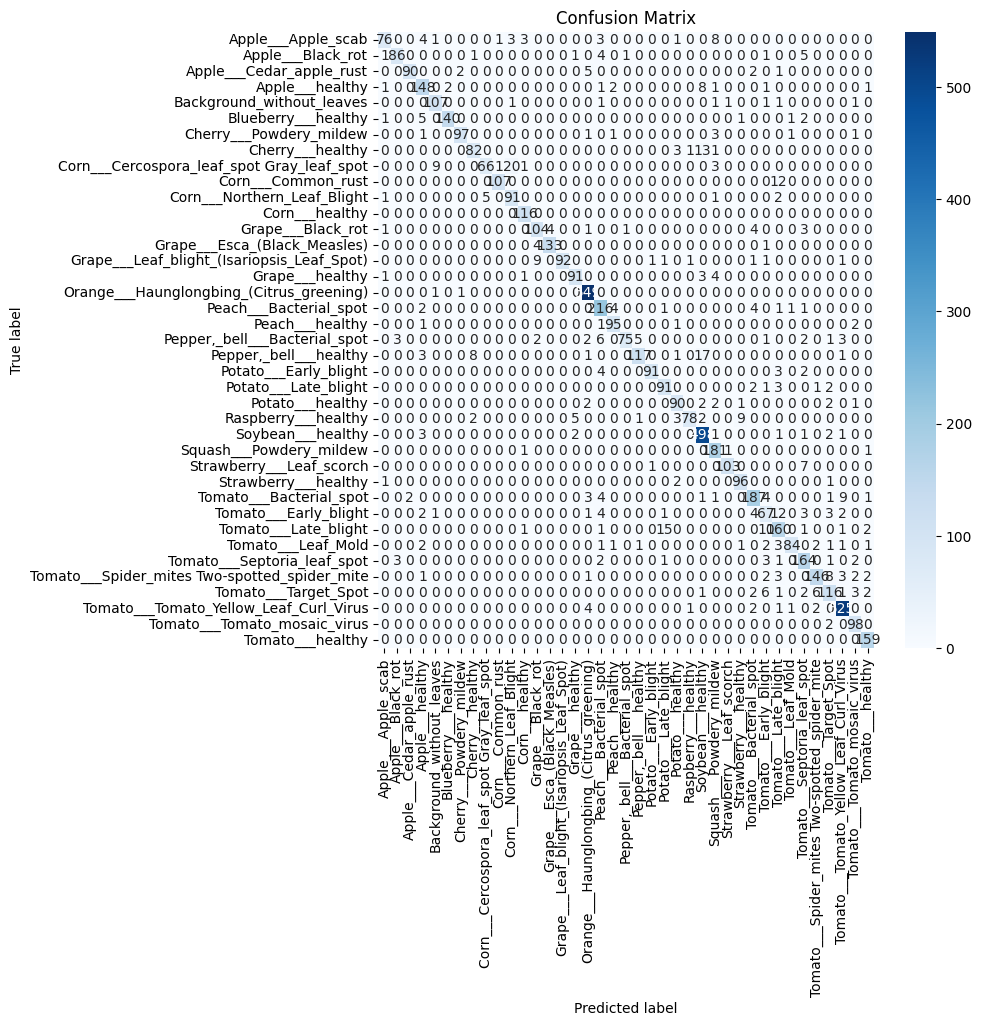

Overall Accuracy: 0.9127

Metrics by Class:
Class                Accuracy   Precision  Recall    
Apple___Apple_scab   0.7600     0.9157     0.7600    
Apple___Black_rot    0.8600     0.9348     0.8600    
Apple___Cedar_apple_rust 0.9000     0.9783     0.9000    
Apple___healthy      0.8970     0.8605     0.8970    
Background_without_leaves 0.9386     0.8992     0.9386    
Blueberry___healthy  0.9333     0.9859     0.9333    
Cherry___Powdery_mildew 0.9238     0.9700     0.9238    
Cherry___healthy     0.8200     0.8817     0.8200    
Corn___Cercospora_leaf_spot Gray_leaf_spot 0.6600     0.9296     0.6600    
Corn___Common_rust   0.8992     0.9817     0.8992    
Corn___Northern_Leaf_Blight 0.9100     0.7913     0.9100    
Corn___healthy       1.0000     0.9431     1.0000    
Grape___Black_rot    0.8814     0.8739     0.8814    
Grape___Esca_(Black_Measles) 0.9638     0.9708     0.9638    
Grape___Leaf_blight_(Isariopsis_Leaf_Spot) 0.8598     1.0000     0.8598    
Grape___healthy      

0.912668726622215

In [14]:
evaluate_model('best_models/h1_80-10-10_classifierA.pth', val_loader, device)